In [4]:
import pysam
import pandas as pd
import pyBigWig
import hdbscan
import networkx as nx
import numpy as np
import bioframe as bf
import statsmodels.api as sm
from scipy.stats import t
import matplotlib.pyplot as plt


In [5]:
def perform_HDBScan_clustering(read_tbl,min_cluster,processes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster,
                        metric='euclidean',
                        core_dist_n_jobs=processes)
    clusterer.fit(read_tbl.loc[:,['start']])

def collect_hdb_cluster_read(g):
    
    leaves = set([v for v, d in g.out_degree() if d == 0])
    HDB_clusters = [v for v, d in g.out_degree() if d > 0]

    cl_read_idx = [list(nx.descendants(g,i).intersection(leaves)) for i in HDB_clusters]
    cl_read_tbl = pd.DataFrame({"HDB_cluster":HDB_clusters,"read_id_set":cl_read_idx})
    return(cl_read_tbl)



In [6]:
ctrl_bam = "/home/vipink/Documents/TFHclust/data/H3K27me3/bam/H3K27me3_ctrl_MCF7_ENCFF433BQD.bam"
obs_bam = "/home/vipink/Documents/TFHclust/data/H3K27me3/bam/H3K27me3_obs_MCF7_ENCFF351EJX.bam"
pvalue_bw_file = "/home/vipink/Documents/TFHclust/data/H3K27me3/bigwig/H3K27me3_pvalue_MCF7_ENCFF195CGX.bigWig"
peak_bed_file = "/home/vipink/Documents/TFHclust/data/H3K27ac/bed/H3K27AC_IDR_peak_ENCFF340KSH.bed"

In [7]:
ctrl_bamfile = pysam.AlignmentFile(ctrl_bam, "rb")
obs_bamfile = pysam.AlignmentFile(obs_bam, "rb")
pvalue_bw = pyBigWig.open(pvalue_bw_file)

In [42]:
peak_df = (pd.read_csv(peak_bed_file,sep="\t",header=None,usecols=[0,1,2,3,4])
 .rename(columns={0:'chrom',1:'start',2:'end',3:'ID',4:'IDR'})
 )

In [8]:
chromo = "chr22"

In [9]:
ctrl_iter = ctrl_bamfile.fetch(chromo)
obs_iter = obs_bamfile.fetch(chromo)

In [10]:
ctrl_dfs = []
for ix in ctrl_iter:
    ctrl_dfs.append(pd.DataFrame({'ID':[ix.to_dict()['name']],'chrom':[ix.to_dict()['ref_name']],'start':[ix.to_dict()['ref_pos']],'flag':[ix.to_dict()['flag']]}))

In [11]:
obs_dfs = []
for ix in obs_iter:
    obs_dfs.append(pd.DataFrame({'ID':[ix.to_dict()['name']],'chrom':[ix.to_dict()['ref_name']],'start':[ix.to_dict()['ref_pos']],'flag':[ix.to_dict()['flag']]}))

In [12]:
bg_df = pd.concat(ctrl_dfs).assign(start = lambda df_: df_.start.astype(int))
read_tbl = pd.concat(obs_dfs).assign(start = lambda df_: df_.start.astype(int))

In [13]:
read_tbl.flag.value_counts()

flag
16    151986
0     151726
Name: count, dtype: int64

In [14]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3,
                    metric='euclidean',
                    core_dist_n_jobs=2)
clusterer.fit(read_tbl.loc[:,['start']])
full_graph = clusterer.condensed_tree_.to_networkx()


/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
tmp_cl_tbl = collect_hdb_cluster_read(full_graph)

In [16]:
long_cl_read_tbl = tmp_cl_tbl.explode('read_id_set')
long_cl_read_tbl = (long_cl_read_tbl
                    .assign(start = lambda df_:read_tbl.reset_index().start.to_numpy()[df_.read_id_set.to_numpy(dtype=int)])
                    )

tmp_chr_hdb_summary_tbl = (long_cl_read_tbl
                                .groupby('HDB_cluster')
                                .agg(start = ('start','min'),
                                     end=('start','max'),
                                     rc = ('start','count')
                                    )
                                .assign(w= lambda df_:df_.end - df_.start)
                            )        


In [17]:
tmp_chr_hdb_summary_tbl = tmp_chr_hdb_summary_tbl.reset_index().merge(tmp_cl_tbl)

In [18]:
bg_coord_df = bg_df.loc[:,['chrom','start']].assign(start = lambda df_: df_.start.astype(int)).assign(end = lambda df_: df_.start + 1)

In [19]:
hdb_cluster_bg_rc_df = bf.count_overlaps(tmp_chr_hdb_summary_tbl.assign(chrom = chromo).loc[:,['chrom','start','end','HDB_cluster']],bg_coord_df)

<Axes: xlabel='bg_count', ylabel='rc'>

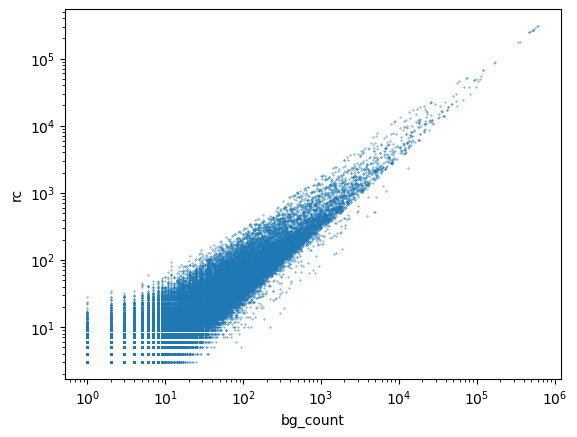

In [20]:
tmp_chr_hdb_summary_tbl.merge(hdb_cluster_bg_rc_df.rename(columns={'count':'bg_count'})).plot.scatter(x='bg_count',y='rc',s=0.1,logx=True,logy=True)

In [21]:
tmp_chr_hdb_summary_tbl = tmp_chr_hdb_summary_tbl.merge(hdb_cluster_bg_rc_df.rename(columns={'count':'bg_count'}))

In [22]:
data_tbl = (tmp_chr_hdb_summary_tbl
            .loc[:,['HDB_cluster','rc','bg_count']]
            .assign(lrc = lambda df_: np.log10(df_.rc), lbg = lambda df_: np.log10(df_.bg_count))
            .assign(lbg2 = lambda df_: np.where(df_.bg_count.lt(1),0,df_.lbg))
            )

/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)


In [23]:
def build_hic_zscore(read_neighbour_df,vars,vars_df,vars_degree):

    x_spline = read_neighbour_df[vars].to_numpy(dtype=float)
    y = read_neighbour_df.lrc.to_numpy(dtype=float)
    bs = sm.gam.BSplines(x_spline, df=vars_df, degree=vars_degree)

    chr_gam = sm.GLMGam(y,smoother=bs)
    chr_gam_res = chr_gam.fit()
    gam_infl = chr_gam_res.get_influence()
    return(gam_infl.resid_studentized)


In [24]:
tmp_zscore = build_hic_zscore(data_tbl,['lbg2'],[10],[3])

<Axes: xlabel='lbg2', ylabel='lrc'>

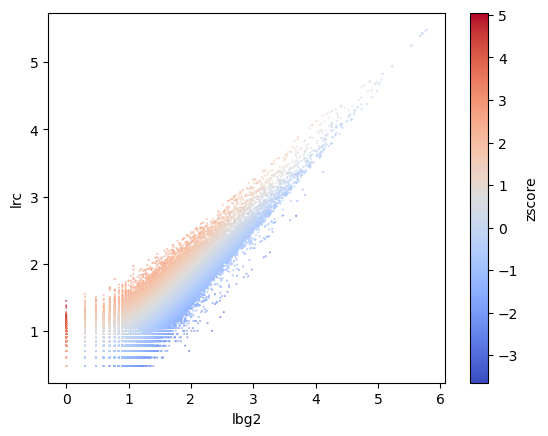

In [25]:
data_tbl.assign(zscore= tmp_zscore).sort_values('zscore').plot.scatter(x='lbg2',y='lrc',c='zscore',s=0.1,cmap='coolwarm')

<Axes: ylabel='Density'>

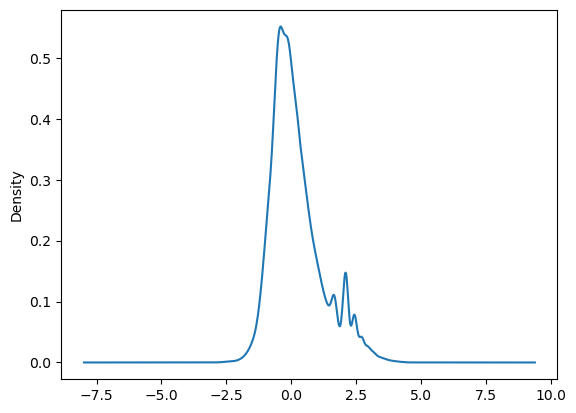

In [26]:
(data_tbl
 .assign(zscore= tmp_zscore)
 .zscore.plot.kde()
)

In [27]:
(data_tbl
 .assign(zscore= tmp_zscore)
 .zscore.median()
)

-0.005461965810143525

<Axes: xlabel='zscore', ylabel='obs_rd'>

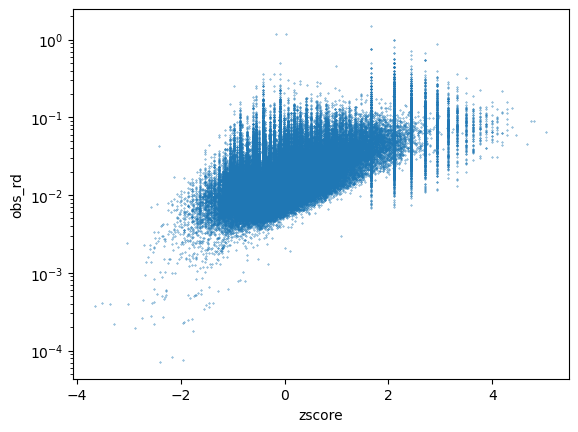

In [28]:
(data_tbl
 .assign(zscore= tmp_zscore)
 .merge(tmp_chr_hdb_summary_tbl.loc[:,['HDB_cluster','chrom','start','end','w']])
 .assign(obs_rd = lambda df_: (df_.rc/df_.w))
 .plot.scatter(x='zscore',y='obs_rd',s=0.1,logy=True)
 )

<Axes: xlabel='zscore', ylabel='FC'>

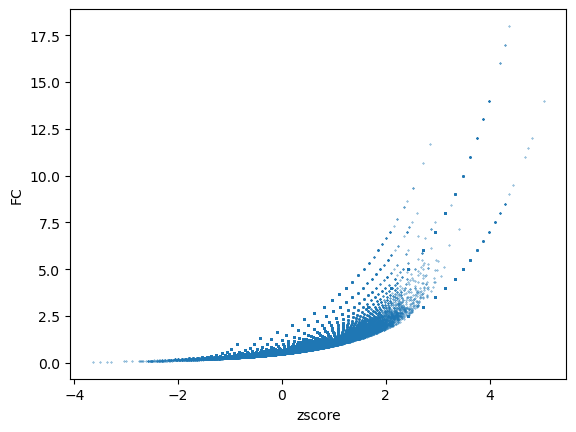

In [29]:
(data_tbl
 .assign(zscore= tmp_zscore)
 .merge(tmp_chr_hdb_summary_tbl.loc[:,['HDB_cluster','chrom','start','end','w']])
 .assign(FC = lambda df_: (df_.rc/df_.w)/((df_.bg_count+1)/df_.w))
 .plot.scatter(x='zscore',y='FC',s=0.1)
 )

<Axes: xlabel='FC', ylabel='MACS_pvalue'>

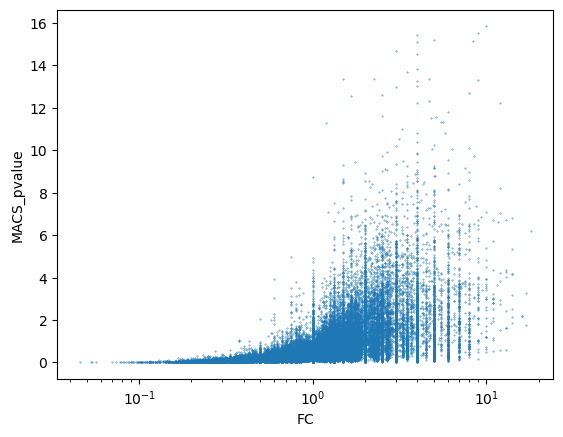

In [30]:
(data_tbl
 .assign(zscore= tmp_zscore)
 .merge(tmp_chr_hdb_summary_tbl.loc[:,['HDB_cluster','chrom','start','end','w']])
 .assign(MACS_pvalue = lambda df_: df_.apply(lambda row: pvalue_bw.stats(row.chrom,row.start,row.end,type="mean")[0],axis=1))
 .assign(FC = lambda df_: (df_.rc/df_.w)/((df_.bg_count+1)/df_.w))
 .plot.scatter(x='FC',y='MACS_pvalue',s=0.1,logx=True)
 )

<Axes: xlabel='zscore', ylabel='MACS_pvalue'>

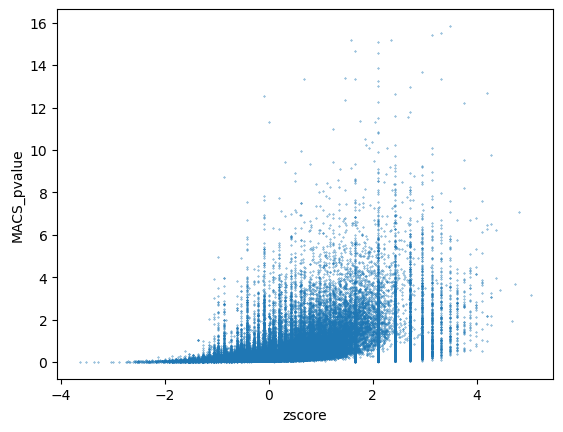

In [31]:
(data_tbl
 .assign(zscore= tmp_zscore)
 .merge(tmp_chr_hdb_summary_tbl.loc[:,['HDB_cluster','chrom','start','end','w']])
 .assign(MACS_pvalue = lambda df_: df_.apply(lambda row: pvalue_bw.stats(row.chrom,row.start,row.end,type="mean")[0],axis=1))
 .assign(FC = lambda df_: (df_.rc/df_.w)/((df_.bg_count+1)/df_.w))
 .plot.scatter(x='zscore',y='MACS_pvalue',s=0.1)
 )

In [32]:
x_spline = data_tbl['lbg2']
y = data_tbl.loc[:,'lrc'].to_numpy()
bs = sm.gam.BSplines(x_spline, df=10, degree=3)

chr_gam = sm.GLMGam(y,smoother=bs)
chr_gam_res = chr_gam.fit()
bs_tranform_exog = bs.transform(data_tbl.loc[:,['lbg2']].to_numpy())
tmp_rng = chr_gam_res.get_distribution(exog=bs_tranform_exog)


<Axes: xlabel='zscore', ylabel='pvalue'>

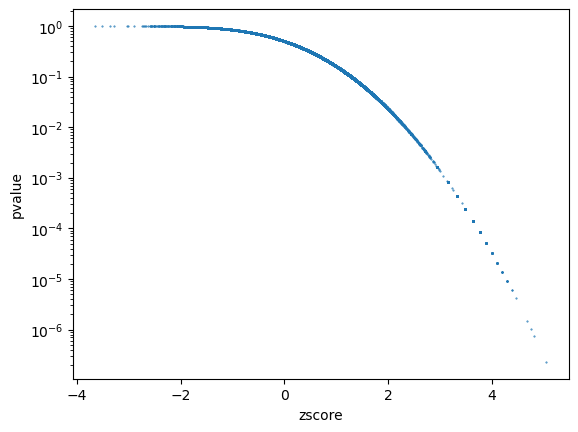

In [33]:
(data_tbl
 .assign(zscore= tmp_zscore)
 .assign(pvalue = tmp_rng.sf(data_tbl.loc[:,'lrc'].to_numpy()))
 .plot
 .scatter(x='zscore',y='pvalue',logy=True,s=0.2)
)

In [34]:
cl_summary_tbl =  (data_tbl
                    .assign(zscore= tmp_zscore)
                    .assign(pvalue = tmp_rng.sf(data_tbl.loc[:,'lrc'].to_numpy()))
                    .merge(tmp_chr_hdb_summary_tbl.loc[:,['HDB_cluster','chrom','start','end','w']])
                    .assign(MACS_pvalue = lambda df_: df_.apply(lambda row: pvalue_bw.stats(row.chrom,row.start,row.end,type="mean")[0],axis=1))
                    .assign(FC = lambda df_: (df_.rc/df_.w)/((df_.bg_count+1)/df_.w))
                  )


<Axes: xlabel='lp', ylabel='MACS_pvalue'>

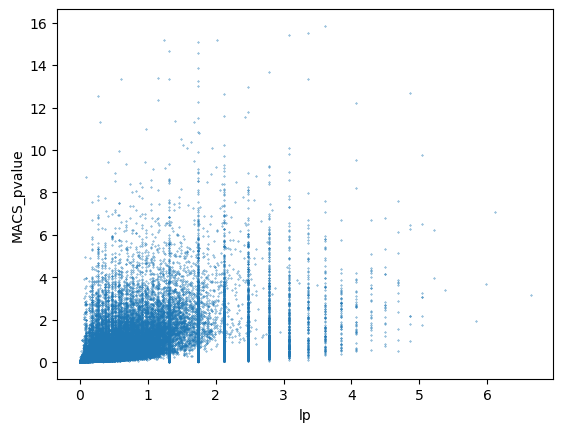

In [75]:
cl_summary_tbl.assign(lp = lambda df_: -np.log10(df_.pvalue)).plot.scatter(x='lp',y='MACS_pvalue',s=0.1)

In [56]:
smooth_window = 150
obs_rcount_bdg = pd.concat([pd.DataFrame({'DNA_pos':read_tbl.start.to_numpy() }).assign(score = 1),
                             pd.DataFrame({'DNA_pos':read_tbl.start.to_numpy() + smooth_window}).assign(score = -1)
                            ]).sort_values('DNA_pos').assign(csum = lambda df_: df_.score.cumsum()).groupby('DNA_pos').agg(rcount = ('csum','max')).reset_index()

bg_rcount_bdg = pd.concat([pd.DataFrame({'DNA_pos':bg_df.start.to_numpy() }).assign(score = 1),
                             pd.DataFrame({'DNA_pos':bg_df.start.to_numpy() + smooth_window}).assign(score = -1)
                            ]).sort_values('DNA_pos').assign(csum = lambda df_: df_.score.cumsum()).groupby('DNA_pos').agg(rcount = ('csum','max')).reset_index()


In [57]:
obs_rcount_bdg = obs_rcount_bdg.assign(rd = lambda df_: df_.rcount/read_tbl.shape[0])
bg_rcount_bdg =bg_rcount_bdg.assign(rd = lambda df_: df_.rcount/bg_df.shape[0])

<Axes: xlabel='rd', ylabel='pvalue'>

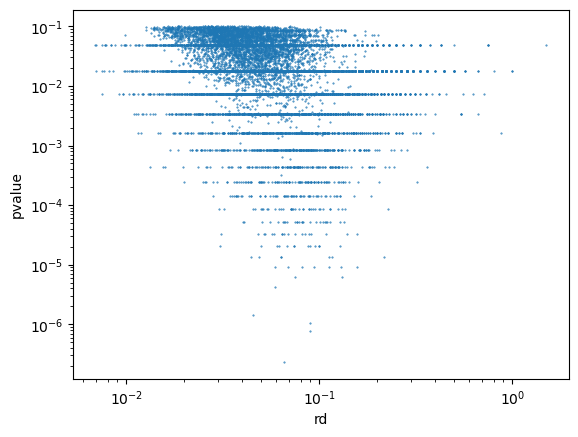

In [77]:
cl_summary_tbl.query("pvalue < 1e-1").assign(rd = lambda df_: df_.rc/df_.w).plot.scatter(x='rd',y='pvalue',logx=True,logy=True,s=0.2)

In [61]:
merged_cl_tbl = bf.merge(cl_summary_tbl.query("zscore > 0.5").loc[:,['chrom','start','end']]).sort_values('start').reset_index(drop=True)
merged_cl_tbl.assign(w = lambda df_: df_.end -df_.start)

,chrom,start,end,n_intervals,w
0,chr22,10716810,10716835,1,25
1,chr22,10717440,10717452,1,12
2,chr22,10930500,10930521,1,21
3,chr22,10932551,10932667,1,116
4,chr22,10933058,10933202,1,144
...,...,...,...,...,...
1633,chr22,47317508,47325155,12,7647
1634,chr22,47330375,47330807,1,432
1635,chr22,47333000,47334711,1,1711
1636,chr22,47348742,48985592,1858,1636850


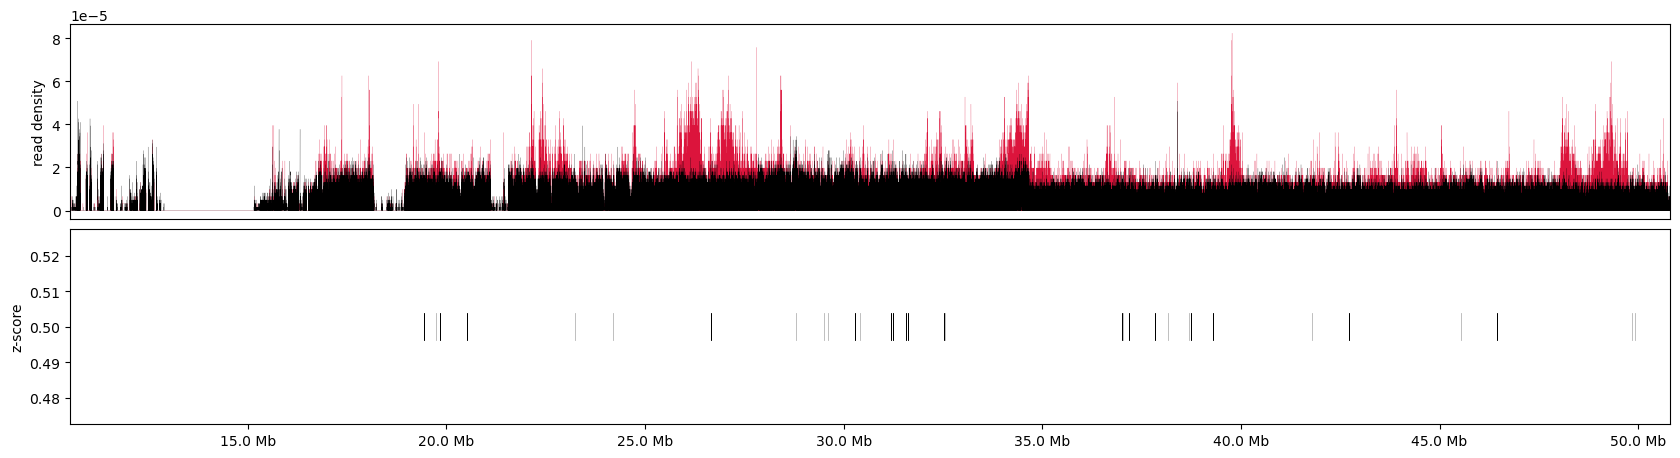

In [68]:
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(2, 1, height_ratios=(1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
plot_window_min = obs_rcount_bdg.DNA_pos.min()
plot_window_max = obs_rcount_bdg.DNA_pos.max()
# plot_window_min = 28_700_000
# plot_window_max = 29_000_000

ax_dens = fig.add_subplot(gs[0, 0],xlim = (plot_window_min,plot_window_max) )
ax_dens.xaxis.set_visible(False)
ax_dens.set_ylabel('read density')

ax_agg = fig.add_subplot(gs[1, 0],sharex=ax_dens)
ax_agg.xaxis.set_major_formatter(lambda x,pos: (str(np.round(x/1e6,decimals=2)) + " Mb"))
ax_agg.xaxis.set_visible(True)
ax_agg.set_ylabel('z-score')

# for bin_idx in range(merged_cl_tbl.shape[0]):
#     tmp_cl =  merged_cl_tbl.iloc[bin_idx,:]
#     tmp_start = tmp_cl.start
#     tmp_end = tmp_cl.end 
#     tmp_h = tmp_cl.n_intervals
#     if bin_idx %2 == 0:
#         ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=20)
#     else:
#         ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='silver',linewidth=20)
tmp_peak_df = bf.merge(peak_df.query('chrom == "chr22"'))
for bin_idx in range(tmp_peak_df.shape[0]):
    tmp_cl =  tmp_peak_df.iloc[bin_idx,:]
    tmp_start = tmp_cl.start
    tmp_end = tmp_cl.end 
    # tmp_h = tmp_cl.n_intervals
    if bin_idx %2 == 0:
        ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=20)
    else:
        ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='silver',linewidth=20)
ax_dens.step(x=obs_rcount_bdg.DNA_pos.to_numpy(),y=obs_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='crimson')
ax_dens.step(x=bg_rcount_bdg.DNA_pos.to_numpy(),y=bg_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='black')


In [67]:
bf.merge(peak_df.query("IDR > 500").query('chrom == "chr22"'))

,chrom,start,end,n_intervals
0,chr22,19479193,19479770,1
1,chr22,28797906,28800215,1
2,chr22,28808984,28813751,1
3,chr22,28814070,28818654,1
4,chr22,28818741,28823063,1
5,chr22,33848878,33852132,1


In [54]:
(bf.overlap(peak_df ,cl_summary_tbl.loc[:,['chrom','start','end','HDB_cluster','zscore','pvalue']],how='outer')
 .assign(out_HDB = lambda df_: df_.HDB_cluster_.isna(),lIDR = lambda df_: np.log10(df_.IDR))
 .out_HDB.mean()
 )

0.34180487172842705

In [87]:
chr_cluster_list = cl_summary_tbl.HDB_cluster.to_list()
cl_leaf_indicator = [len(set(next(nx.bfs_successors(full_graph,i))[1]).intersection(chr_cluster_list)) for i in chr_cluster_list]


<Axes: xlabel='zscore', ylabel='lrc'>

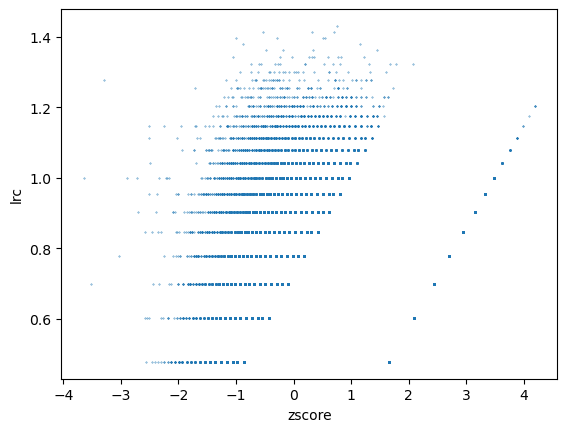

In [96]:
cl_summary_tbl.merge(pd.DataFrame({'HDB_cluster':chr_cluster_list,'leaf_indicator':cl_leaf_indicator})).query('leaf_indicator == 0').plot.scatter(x='zscore',y='lrc',s=0.1)

In [73]:
chr_cluster_list[0]

303712

In [77]:
len(set(next(nx.bfs_successors(full_graph,chr_cluster_list[0]))[1]).intersection(chr_cluster_list))

2